# CSE327 Homework 4
**Due date: 23:59 on Nov. 20, 2018 (Thuesday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 100 points. There is no bonus question for this homework. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
You will be using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [1]:
# import packages here

#Versions used:-
# Python:- 2.7.15
# Torch:- 1.0.0
#OS:- Linux Ubuntu 18.04



import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from time import time


from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util



import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, models, transforms
import os
import time

In [2]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]


# ==========================================
#      Random Rotate Data Augmentation
# ==========================================
def random_rotation(image_array):
    # pick a random degree of rotation between 90 degress on the left and 90 degrees on the right
    random_degree = random.uniform(-90, 90)
    return sk.transform.rotate(image_array, random_degree)

# ==========================================
#      Random Crop Data Augmentation
# ==========================================
def randomCrop(img,width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    return img


# ==========================================
#           Loading Data 
# ==========================================
def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, 
                 augment=False, is_color=False, norm=False, rotate = False, crop = False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
    # norm data to zero-centered
    if norm:
        print("Includes normalizing")
        mean_img = np.mean(np.array(data), 0)
        data = data - mean_img
        data = [data[i] for i in xrange(data.shape[0])]
    
    # augment data
    if augment:
        print("Includes augmentation(vertically flipping images)")
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)
        
    #rotate data    
    if rotate:
        print("Includes rotated images")
        rot_data = [random_rotation(img) for img in data]
        data.extend(rot_data)
        labels.extend(labels)
        
    #crop data    
    if crop:
        print("Includes random cropping")
        crop_data = [randomCrop(img, 50,50) for img in data]
        crop_resize = [cv2.resize(img, (64,64), cv2.INTER_LINEAR) for img in crop_data]
        data.extend(crop_resize)
        labels.extend(labels)
        
    
    # randomly permute (this step is important for training)
    if shuffle:
        print("Includes shuffling images")
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d).float())

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'LivingRoom', 1: 'Highway', 2: 'Mountain', 3: 'Store', 4: 'InsideCity', 5: 'Street', 6: 'Suburb', 7: 'Bedroom', 8: 'TallBuilding', 9: 'OpenCountry', 10: 'Coast', 11: 'Forest', 12: 'Kitchen', 13: 'Industrial', 14: 'Office'}


In [3]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True,norm=False))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))




# Inlcudes training dataset along with random rotation
trainloader_rotate = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                       rotate = True))



#Includes training dataset with random cropping
trainloader_crop = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                       crop = True))


# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small[0][1])
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Includes augmentation(vertically flipping images)
Includes shuffling images
3000
Finish loading 60 minibatches(=50) of training samples.
Includes rotated images
Includes shuffling images
3000
Includes random cropping
Includes shuffling images
3000
1500
Finish loading 50 minibatches(=50) of testing samples.


Office


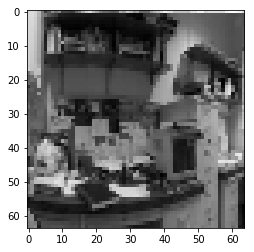

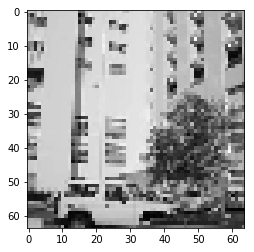

In [4]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

<div class="alert alert-info"><h3>Report</h3>

**Hardware Details:-**<br>

        Intel Core i7-6500U Processor (2.5GHz Base, up to 3.1GHz Turbo)
        RAM:- 16 GB
        Intel HD Graphics 520
    ----------------------------------------------------------------------------------------------------

**Part I:-**

``Data augmentation``: <br> 
    
        For training data that have very few images, data augmentation becomes handy. 
        Here I have used vertical flipping operation to augment the original images
        with their flipped images to increase size of the training data. So, this doubles 
        the training data from 1500 images to 3000 images. We can even do random image 
        rotations/cropping to increase the training data set.
        trainloader_small =  Includes original + flipped images        (1500 + 1500)
        trainloader_rotate = Includes original + random rotated images (1500 + 1500)
        trainloader_crop =   Includes original + random cropped images  (1500 + 1500)
        -------------------------------------------------------------------------------------------------
        
``Data normalization:`` <br>

        In general, the images in the dataset are not normalized. Mean normalization is one
        of the common techinque that helps to normalize the images and by doing this 
        there is slight increase in the accuracy. We do this by calculating the mean of each
        image and subtract that mean from the original image to get the normalized image.
        All images have been normalized and then used for data augmentation.
    ----------------------------------------------------------------------------------------------------

**Detailed descriptions of my network layout:-** <br>


``Layer 1:[convolutional_layer]:`` <br>

        The is a convolutional layer. 
        self.conv1 = nn.Conv2d(1,6, kernel_size = 5) , the number of input channels is 1 since we 
        are not using color images, number output channels is given as 6 and kernel size for 
        this layer is taken as 5.
        

``Layer 2:[convolutional_layer]:`` <br>
        
        This is a convolutional layer.
        self.conv2 = nn.Conv2d(6, 16, 5), the number of input channels is 6 which is output of
        the previous layer, number of output channels for this layer is taken as 16 and kernel
        size is taken as 5. 


``Layer 3:[linear_layer]:`` <br>
        
        This is a linear layer.
        self.fc1 = nn.Linear(2704, 15), the number of input channels is 2704 (calculated as 16*13*13)
        which is output of the previous layer (from conv2), number of output channels for this
        layer is taken as 15 which is the number of classes that we are trying to predict. 

``Optimizer:`` <br>

        I am using Stochastic gradient descent (SGD) that is a variant of Gradient descent
        which is quicker than Gradient Descent. I have used this optmizer with learning rate
        = 0.01 and momentum = 0.9
    ----------------------------------------------------------------------------------------------------
    
**Part II:-**

    Training took 520.082 secs (30 epochs)
    Testing took 3.029 secs (30 epochs)

    Training took 194.058 secs (10 epochs) 
    Testing took 3.386 secs  (10 epochs)

    Training took 40.595 secs (2 epochs)
    Testing took 3.249 secs (2 epochs)
    ----------------------------------------------------------------------------------------------------

 <i> <h5> Different activation functions</h5> </i><br>
 
      I have explored and tried three different activation functions namely Tanh, Sigmoid and ReLU. 
      Tanh was performing very good while sigmoid showed worst performance. As explained above for
      epochs  = 30 the loss was converging to zero (approx) for Tanh and ReLU while for sigmoid it
      was not converging to zero. As we can see the table below shows that Tanh activation function
      shows the best accuracy. 
    ----------------------------------------------------------------------------------------------------
<div class="tg-wrap"><table class='table table-striped'>
  <tr>
    <th>Activation Function<br> (learning rate = 0.01)</th>
    <th>Epochs = 2</th>
    <th>Epochs = 10</th>
    <th>Epochs = 30</th>

  </tr>
  <tr>
    <td>Tanh</td>
    <td>30%</td>
    <td>43%</td>
    <td><span style="font-weight:bold">47%</span></td>
  </tr>
  <tr>
    <td>Sigmoid</td>
    <td>6%</td>
    <td>6%</td>
    <td>10%</td>
  </tr>
  <tr>
    <td>Relu</td>
    <td>22%</td>
    <td>36%</td>
    <td>41%</td>
  </tr>
</table></div>


 <i> <h5> Adding Batch Normalization</h5> </i> <br>
 
      I have implemented batch normalization at Conv Layers as well as Linear Layers. 
      Implemented using nn.BatchNorm2d(), this is used for normalizing the output
      of the convolutional layer and nn.BatchNorm1d(), this is used for normalizing
      th output of the linear layers.
     ----------------------------------------------------------------------------------------------------
<div class="tg-wrap"><table class='table table-striped'>
  <tr>
    <th>Activation Function<br> (learning rate = 0.01)</th>
    <th>Epochs = 2</th>
    <th>Epochs = 10</th>
    <th>Epochs = 30</th>

  </tr>
  <tr>
    <td>Tanh</td>
    <td>30%</td>
    <td>42%</td>
    <td>45%</td>
  </tr>
  <tr>
    <td>Sigmoid</td>
    <td>6%</td>
    <td>6%</td>
    <td>9%</td>
  </tr>
  <tr>
    <td>Relu</td>
    <td>18%</td>
    <td>40%</td>
    <td>43%</td>
  </tr>
</table></div>


 <i> <h5> Random Rotations (Data Augmentation)</h5> </i>
 
 
    Data augmentation with randomly rotated images (-90 degrees to +90 degrees)
    -----------------------------------------------------------------------------------------------
 
<div class="tg-wrap"><table class='table table-striped'>
  <tr>
    <th>Activation Function<br> (learning rate = 0.01)</th>
    <th>Epochs = 2</th>
    <th>Epochs = 10</th>
    <th>Epochs = 30</th>

  </tr>
  <tr>
    <td>Tanh</td>
    <td>32%</td>
    <td>35%</td>
    <td>34%</td>
  </tr>
  <tr>
    <td>Sigmoid</td>
    <td>5%</td>
    <td>6%</td>
    <td>8%</td>
  </tr>
  <tr>
    <td>Relu</td>
    <td>15%</td>
    <td>33%</td>
    <td>37%</td>
  </tr>
</table></div>



 <i> <h5> Random Cropping (Data Augmentation)</h5> </i>
 
 
    Data augmentation with randomly cropped images
    -----------------------------------------------------------------------------------------------
 
<div class="tg-wrap"><table class='table table-striped'>
  <tr>
    <th>Activation Function<br> (learning rate = 0.01)</th>
    <th>Epochs = 2</th>
    <th>Epochs = 10</th>
    <th>Epochs = 30</th>

  </tr>
  <tr>
    <td>Tanh</td>
    <td>27%</td>
    <td>39%</td>
    <td><span style="font-weight:bold">39%</span></td>
  </tr>
  <tr>
    <td>Sigmoid</td>
    <td>6%</td>
    <td>8%</td>
    <td>8%</td>
  </tr>
  <tr>
    <td>Relu</td>
    <td>13%%</td>
    <td>32%</td>
    <td>35%</td>
  </tr>
</table></div>




In [200]:
# ==========================================
#       Define Network Architecture
# ==========================================

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6, kernel_size = 5)
        self.drop = nn.Dropout2d(p=0.6, inplace=False)   #Dropout layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(2704, 15)
        self.dense1_bn = nn.BatchNorm1d(15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = self.conv1_bn(x)
        x = F.tanh(x)
        x = self.pool(x)
        
        x = self.conv2(x)
#         x = self.drop(x)
#         x = self.conv2_bn(x)
        x = F.tanh(x)
        x = self.pool(x)
        
        x = x.view(-1,2704)
        
        x = self.fc1(x)
        x = self.dense1_bn(x)
        return 

In [203]:
# ==========================================
#         Optimize/Train Network
# ==========================================


net = Net()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

t0 = time.time()
net.train()
for epoch in range(90):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader_small, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 60 == 59:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 60))
            running_loss = 0.0

print('Finished Training')

print('Training complete in {:.0f}m {:.0f}s'.format((time.time()-t0) // 60, (time.time()-t0) % 60))

[1,    60] loss: 2.569
[2,    60] loss: 2.378
[3,    60] loss: 2.248
[4,    60] loss: 2.137
[5,    60] loss: 2.014
[6,    60] loss: 1.899
[7,    60] loss: 1.786
[8,    60] loss: 1.697
[9,    60] loss: 1.569
[10,    60] loss: 1.486
[11,    60] loss: 1.369
[12,    60] loss: 1.233
[13,    60] loss: 1.126
[14,    60] loss: 1.044
[15,    60] loss: 0.936
[16,    60] loss: 0.864
[17,    60] loss: 0.794
[18,    60] loss: 0.729
[19,    60] loss: 0.696
[20,    60] loss: 0.646
[21,    60] loss: 0.610
[22,    60] loss: 0.568
[23,    60] loss: 0.549
[24,    60] loss: 0.541
[25,    60] loss: 0.485
[26,    60] loss: 0.517
[27,    60] loss: 0.440
[28,    60] loss: 0.453
[29,    60] loss: 0.452
[30,    60] loss: 0.395
[31,    60] loss: 0.391
[32,    60] loss: 0.413
[33,    60] loss: 0.402
[34,    60] loss: 0.354
[35,    60] loss: 0.383
[36,    60] loss: 0.337
[37,    60] loss: 0.347
[38,    60] loss: 0.340
[39,    60] loss: 0.322
[40,    60] loss: 0.327
[41,    60] loss: 0.324
[42,    60] loss: 0.328
[

In [204]:
# ==========================================
#            Evaluating Network
# ==========================================

correct = 0
total = 0
t0 = time.time()
net.eval()
with torch.no_grad():
    for data in testloader_small:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Testing complete in {:.0f}m {:.0f}s'.format((time.time()-t0) // 60, (time.time()-t0) % 60))
print('Accuracy of the network on the 1500 test images: %d %%' % (100 * correct / total))

Testing took 5.060 secs
Accuracy of the network on the 1500 test images: 35 %


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

<div class="alert alert-info"><h3>Report</h3><br>

**Hardware Details:-**<br>

        Intel Core i7-6500U Processor (2.5GHz Base, up to 3.1GHz Turbo)
        RAM:- 16 GB
        Intel HD Graphics 520
    ----------------------------------------------------------------------------------------------------


**(1) Which layers of AlexNet have been replaced**<br>

      Strategy B:- I have only replaced the last layer of AlexNet so that I get 
      the output as 15 classes that we require in our problem.
      
      
      Strategy A:-For this strategy,  as per the requirment the number of avctivations for 
      the last layer were kept untouched. And no layers were replaced.
      

**(2) the architecture of the new layers added including activation methods (same as problem 1)**<br>

       Strategy B:- No new layers were added in my architecture. Last layer of alexNet was used 
        to fine tune the network. And training was done on that network.

        Strategy A:- No change in the architecture of AlexNet
        

**(3) the final accuracy on test set along with time consumption for both training and testing**<br>
        
        Strategy B:-
        Training complete in 107m 37s
        Test Accuracy: 87.0352%
        Testing complete in 3m 25s
        
        
        Strategy A:-
        Training complete in 0m 14s
        Accuracy(%):-80.4
        Testing complete in 1m 16s
        
        Hyper paramenters used:-
        (strategy-B)
        learning_rate = 0.001 (SGD)
        epochs:- 30
        momentum:- 0.9 (SGD)
        optmizier:- stochastic gradient descent
        (strategy-A)
        max_iter in LinearSVC:- 1000
        
        


In [93]:

# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================


# reload data with a larger size
img_size = (224, 224)
batch_size = 50 # training sample number per batch 
num_classes = 15
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    model_ft = models.alexnet(pretrained=use_pretrained)
#     set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size


# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract = True, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [94]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join('data/', x), data_transforms[x]) for x in ['train', 'test']}


dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

Initializing Datasets and Dataloaders...


In [95]:
model_ft = model_ft.to('cpu')

feature_extract = False
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

learning_rate = 0.001
optimizer_ft = optim.SGD(params_to_update, lr = learning_rate, momentum=0.9)

Params to learn:
('\t', 'features.0.weight')
('\t', 'features.0.bias')
('\t', 'features.3.weight')
('\t', 'features.3.bias')
('\t', 'features.6.weight')
('\t', 'features.6.bias')
('\t', 'features.8.weight')
('\t', 'features.8.bias')
('\t', 'features.10.weight')
('\t', 'features.10.bias')
('\t', 'classifier.1.weight')
('\t', 'classifier.1.bias')
('\t', 'classifier.4.weight')
('\t', 'classifier.4.bias')
('\t', 'classifier.6.weight')
('\t', 'classifier.6.bias')


In [96]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(1,num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        phase = 'train'
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset))*100

        print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [97]:
def test_model(model , dataloaders):
    model.eval()
    since = time.time()
    total = 0
    correct = 0
    phase = 'test'
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_acc = ((correct*1.0) / len(dataloaders['test'].dataset)) *100

    print('{} Acc: {:.4f}%'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
#     return model

In [98]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
num_epochs = 30
# Train and evaluate
model_ft  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/30
----------
train Loss: 1.6092 Acc: 48.2000%
Epoch 2/30
----------
train Loss: 0.8498 Acc: 70.6000%
Epoch 3/30
----------
train Loss: 0.7346 Acc: 74.3333%
Epoch 4/30
----------
train Loss: 0.6805 Acc: 77.4000%
Epoch 5/30
----------
train Loss: 0.6145 Acc: 79.6667%
Epoch 6/30
----------
train Loss: 0.5940 Acc: 79.6000%
Epoch 7/30
----------
train Loss: 0.5885 Acc: 79.6667%
Epoch 8/30
----------
train Loss: 0.5217 Acc: 81.9333%
Epoch 9/30
----------
train Loss: 0.5595 Acc: 80.6667%
Epoch 10/30
----------
train Loss: 0.5439 Acc: 80.8000%
Epoch 11/30
----------
train Loss: 0.5271 Acc: 81.4667%
Epoch 12/30
----------
train Loss: 0.4592 Acc: 84.6000%
Epoch 13/30
----------
train Loss: 0.4925 Acc: 83.9333%
Epoch 14/30
----------
train Loss: 0.4202 Acc: 85.6667%
Epoch 15/30
----------
train Loss: 0.4823 Acc: 84.4000%
Epoch 16/30
----------
train Loss: 0.3958 Acc: 86.2000%
Epoch 17/30
----------
train Loss: 0.4299 Acc: 84.6667%
Epoch 18/30
----------
train Loss: 0.4347 Acc: 85.6667%
E

In [99]:
test_model(model_ft, dataloaders_dict)

test Acc: 86.1307%
Testing complete in 2m 48s


In [3]:
# =========================================
#       Strategy A
# ==========================================
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True,norm=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
batch_num = 50
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num,is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Includes augmentation(vertically flipping images)
Includes shuffling images
3000
Finish loading 60 minibatches(=50) of training samples.
1500
Finish loading 30 minibatches(=50) of testing samples.


In [102]:
from sklearn.svm import LinearSVC

model_ft = models.alexnet(pretrained=True)

train_labels = []
train_act = np.empty(shape=[0,1000])


for i, data in enumerate(trainloader_large, 0):
        inputs, labels = data
        outputs = model_ft(inputs)
        
        train_act = np.vstack((train_act,outputs.detach().numpy().reshape(50,1000)))
        train_labels.append(labels.detach().numpy())

In [103]:
print(train_act.shape)
l=[]
for i in train_labels:
    for j in i:
        l.append(j)
l= np.asarray(l).flatten()
print(l.shape)
print(l)

since = time.time()

clf = LinearSVC(max_iter=1000)
clf.fit(train_act, l)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

(3000, 1000)
(3000,)
[10  0  9 ... 14  6  4]
Training complete in 0m 14s


In [105]:
since = time.time()
predicted_labels = []
test_labels = []

model_ft.eval()
for i, data in enumerate(testloader_large, 0):
    
        inputs, labels = data
        outputs = model_ft(inputs)

        test_pred = clf.predict(outputs.detach().numpy().reshape(50,1000))
        predicted_labels.append(test_pred)
        
        test_labels.append(labels.detach().numpy())


pred = []    
for i in predicted_labels:
    for j in i:
        pred.append(j)

test_l = []    
for i in test_labels:
    for j in i:
        test_l.append(j)


count=0
for i in range(len(pred)):
    if pred[i] == test_l[i]:
        count = count + 1

accuracy = ((count*1.0) / len(test_l))*100
print("Accuracy(%):-" + str(accuracy))
time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Accuracy(%):-80.4
Testing complete in 1m 16s


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

<!--Write your report here in markdown or html-->
